In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.conf import SparkConf

conf = SparkConf().setAll([('spark.master', 'yarn'),('spark.executor.memory', '3g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','3g')])
sc = SparkContext(conf=conf)

spark = (SparkSession(sc)
         .builder
         .appName("Onibus")
         .config("spark.sql.broadcastTimeout", "36000")
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-02-21 22:05:48,755 WARN spark.SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
2022-02-21 22:05:49,705 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2022-02-21 22:05:49,705 WARN util.Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
2022-02-21 22:05:49,706 WARN util.Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
2022-02-21 22:05:49,706 WARN util.Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


# Análises

Nesse módulo vamos somente utilizar os dados já pré-processados em outros arquivos.

In [2]:
from pyspark.sql.functions import *
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt

In [3]:
#Lendo o arquivo já enriquecido com os bairros
path = 'hdfs://spark01:9000/user/leonardo-figueiredo/onibus.parquet'
df = (spark.read
           .format('parquet')
           .load(path)
           )

Transformar o tipo da coluna 'DTHR' em timestamp.

In [4]:
df = (df
      .withColumn('DTHR', to_timestamp(col('DTHR'), 'dd/MM/yy HH:mm:ss'))
      .withColumn('COD_LINHA', col('COD_LINHA').cast('int'))
      .withColumn('LAT', col('LAT').cast('float'))
      .withColumn('LON', col('LON').cast('float'))
      .withColumn('HOUR', date_format('DTHR', 'HH:mm:ss'))
      .withColumn('DATE', to_date('DTHR'))
     )

In [157]:
df.show(n=10, truncate=False)

+---------+-------------------+----------+----------+-----+-----------------------------+--------+----------+
|COD_LINHA|DTHR               |LAT       |LON       |VEIC |BAIRRO                       |HOUR    |DATE      |
+---------+-------------------+----------+----------+-----+-----------------------------+--------+----------+
|658      |2017-05-18 07:40:27|-25.494461|-49.327496|HA239|Cidade Industrial de Curitiba|07:40:27|2017-05-18|
|658      |2017-05-18 07:40:25|-25.494476|-49.327435|HA239|Cidade Industrial de Curitiba|07:40:25|2017-05-18|
|658      |2017-05-18 07:40:21|-25.494583|-49.327065|HA239|Cidade Industrial de Curitiba|07:40:21|2017-05-18|
|658      |2017-05-18 07:40:19|-25.494642|-49.326843|HA239|Cidade Industrial de Curitiba|07:40:19|2017-05-18|
|658      |2017-05-18 07:39:58|-25.49523 |-49.324703|HA239|Cidade Industrial de Curitiba|07:39:58|2017-05-18|
|658      |2017-05-18 07:39:56|-25.49527 |-49.324554|HA239|Cidade Industrial de Curitiba|07:39:56|2017-05-18|
|658      

## 1) Encontrar regiões com maior fluxo nos períodos do dia

Vamos separar horários em dia, tarde e noite e identificar as 3 regiões com maior fluxo nesses horários. Para isso, primeiro vamos separar os registros nos três períodos do dia, tomando como manhã o período entre 06h e 11h59, tarde o intervalo de 12h às 17h59, noite de 18h às 11h59 e madrugada de 00:00 às 05:59.

In [176]:
df = (df.withColumn('DAY_PERIOD', 
                     when(col('HOUR').between('06:00:00', '11:59:59'), 'morning')
                    .when(col('HOUR').between('12:00:00', '17:59:59'), 'afternoon')
                    .when(col('HOUR').between('18:00:00', '23:59:59'), 'night')
                    .otherwise('late_night'))
     )

In [178]:
count_period = df.groupBy('DAY_PERIOD').count().toPandas()
count_period

,DAY_PERIOD,count
0,afternoon,20415971
1,late_night,2291350
2,night,18660515
3,morning,22601665


Plotar os resultados

In [184]:
count_period.DAY_PERIOD = count_period.DAY_PERIOD.replace(['afternoon', 'late_night', 'night', 'morning'], ['Tarde', 'Madrugada', 'Noite', 'Manhã'])
count_period['order'] = [2, 4, 3, 1]
count_period

,DAY_PERIOD,count,order
0,Tarde,20415971,2
1,Madrugada,2291350,4
2,Noite,18660515,3
3,Manhã,22601665,1


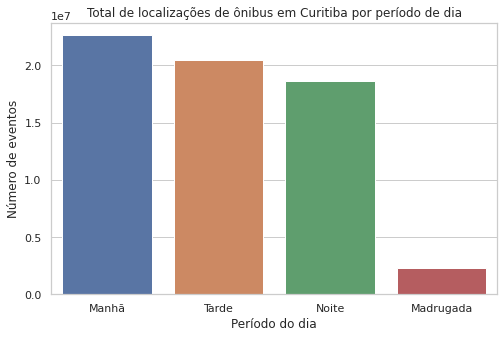

In [359]:
plt.figure(figsize=(8, 5))
sns.barplot(x='DAY_PERIOD', y='count', data=count_period.sort_values(by='order'))
plt.xlabel('Período do dia')
plt.ylabel('Número de eventos')
plt.title('Total de localizações de ônibus em Curitiba por período de dia')
plt.show()

Vamos utilizar somente as informações de período do dia, data, veículo, hora e bairro para fazer a contagem. Vamos tamvém agrupar pode tudo menos por hora para obter a hora fechada em que cada ônibus estava em cada região naquele período do dia. Com isso, podemos remover as linhas duplicadas para excluir coletas do mesmo ônibus naquela região, no determinado período do dia para não considerar ônibus que possam ter muitas rotas no mesmo bairro como alto fluxo.

In [188]:
df = df.select('DAY_PERIOD', 'DATE', 'VEIC', 'HOUR', 'BAIRRO')

In [189]:
#Contar a ocorrência de cada ônibus em cada região em períodos dos dias
df = (df
      .withColumn("ROUND_TIME", substring('HOUR', 0, 2).cast('int'))
      .select('DAY_PERIOD', 'DATE', 'VEIC', 'BAIRRO', 'ROUND_TIME')
      .dropDuplicates()
     )
df = df.groupBy('DAY_PERIOD', 'DATE', 'VEIC', 'BAIRRO').count()

In [190]:
#Somar a quantidade de ônibus que estavam em cada região de acordo com os períodos do dia 
df = (df
      .select('DAY_PERIOD','BAIRRO', 'count')
      .groupBy('DAY_PERIOD','BAIRRO')
      .agg(sum('count').alias('BUS_TOTAL'))
     )

Selecionar as três regiões com maior total de ônibus por cada período do dia (manhã, tarde, noite e madrugada).

In [191]:
from pyspark.sql.window import Window

In [192]:
w1 = Window.partitionBy(df['DAY_PERIOD']).orderBy(df['BUS_TOTAL'].desc())

In [193]:
df_final_1 = (df
      .select('*', row_number().over(w1).alias('row_number')) 
      .filter(col('row_number') <= 3)
     )

In [194]:
df_1 = df_final_1.toPandas()
df_1

,DAY_PERIOD,BAIRRO,BUS_TOTAL,row_number
0,afternoon,Centro,30255,1
1,afternoon,Rebouças,19977,2
2,afternoon,Capão Raso,14406,3
3,late_night,Cidade Industrial de Curitiba,3441,1
4,late_night,Centro,2377,2
5,late_night,Capão Raso,2332,3
6,night,Centro,25846,1
7,night,Rebouças,17730,2
8,night,Capão Raso,13820,3
9,morning,Centro,32510,1


In [195]:
df_1.DAY_PERIOD = df_1.DAY_PERIOD.replace(['afternoon', 'late_night', 'night', 'morning'], ['Tarde', 'Madrugada', 'Noite', 'Manhã'])
df_1['order'] = [2,2,2,4,4,4,3,3,3,1,1,1]

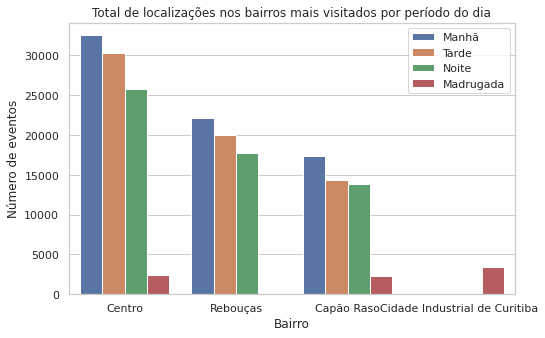

In [360]:
plt.figure(figsize=(8, 5))
sns.barplot(x='BAIRRO', y='BUS_TOTAL', hue='DAY_PERIOD', data=df_1.sort_values(by='order'))
plt.xlabel('Bairro')
plt.ylabel('Número de eventos')
plt.title('Total de localizações nos bairros mais visitados por período do dia')
plt.legend(loc='upper right')
plt.show()

## 2) Características das regiões com maior fluxo

Vamos explorar as características das regiões encontradas na questão anterior.

#### 2.1) Características compiladas dos setores censitários dos bairros

Primeiramente vamos selecionar filtrar da base de setores censitários de cada bairro, somente as informações relevantes e agrupar algumas delas para sintetização.

In [5]:
import pandas as pd

In [7]:
bairros_final = df_final_1.select('BAIRRO').distinct().collect()
bairros_final = [b.BAIRRO for b in bairros_final]
bairros_final

['Centro', 'Rebouças', 'Capão Raso', 'Cidade Industrial de Curitiba']

In [8]:
df_setor = pd.read_csv('censo_curitiba_completo.csv')
display(df_setor.head(5))
print(df_setor.columns)
df_setor = spark.createDataFrame(df_setor)

,Cod_bairro,Cod_distrito,Cod_meso,Cod_municipio,Cod_subdistrito,Nome_Grande_Regiao,Nome_da_UF,Nome_do_municipio,Nome_do_subdistrito,Situacao_setor,...,n_idade_51_60,n_idade_61_70,n_idade_71_100,n_indigenas,n_moradores,n_mulheres,n_pardos,n_pretos,variancia_moradores_por_domicilio,NM_BAIRRO
0,4.106902e+09,410690205.0,4110.0,4106902.0,41069020501,Região Sul,Paraná,CURITIBA,ADMINISTRAÇÃO REGIONAL DA MATRIZ (R.1.MZ),1.0,...,43.0,35.0,28.0,0.0,505.0,280.0,71.0,9.0,1.62,Centro
1,4.106902e+09,410690205.0,4110.0,4106902.0,41069020501,Região Sul,Paraná,CURITIBA,ADMINISTRAÇÃO REGIONAL DA MATRIZ (R.1.MZ),1.0,...,59.0,38.0,68.0,1.0,578.0,333.0,55.0,12.0,1.51,Centro
2,4.106902e+09,410690205.0,4110.0,4106902.0,41069020501,Região Sul,Paraná,CURITIBA,ADMINISTRAÇÃO REGIONAL DA MATRIZ (R.1.MZ),1.0,...,51.0,28.0,50.0,1.0,492.0,266.0,51.0,9.0,1.37,Centro
3,4.106902e+09,410690205.0,4110.0,4106902.0,41069020501,Região Sul,Paraná,CURITIBA,ADMINISTRAÇÃO REGIONAL DA MATRIZ (R.1.MZ),1.0,...,46.0,35.0,38.0,0.0,369.0,221.0,19.0,15.0,1.95,Centro
4,4.106902e+09,410690205.0,4110.0,4106902.0,41069020501,Região Sul,Paraná,CURITIBA,ADMINISTRAÇÃO REGIONAL DA MATRIZ (R.1.MZ),1.0,...,83.0,57.0,89.0,0.0,684.0,399.0,13.0,7.0,2.21,Centro


Index(['Cod_bairro', 'Cod_distrito', 'Cod_meso', 'Cod_municipio',
       'Cod_subdistrito', 'Nome_Grande_Regiao', 'Nome_da_UF',
       'Nome_do_municipio', 'Nome_do_subdistrito', 'Situacao_setor',
       'Tipo_setor', 'media_moradores_por_domicilio',
       'media_rendimento_medio_por_morador_com_ou_sem_renda',
       'media_rendimento_medio_por_morador_com_renda',
       'media_rendimento_medio_por_morador_reponsavel_com_ou_sem_Renda',
       'media_rendimento_medio_por_morador_responsavel_com_renda',
       'n_alfabetizados_homens', 'n_alfabetizados_mulheres', 'n_amarelos',
       'n_brancos', 'n_domicilios', 'n_homens', 'n_idade_0_10',
       'n_idade_11_20', 'n_idade_21_30', 'n_idade_31_40', 'n_idade_41_50',
       'n_idade_51_60', 'n_idade_61_70', 'n_idade_71_100', 'n_indigenas',
       'n_moradores', 'n_mulheres', 'n_pardos', 'n_pretos',
       'variancia_moradores_por_domicilio', 'NM_BAIRRO'],
      dtype='object')


In [9]:
#Manter somente as informações mais relevantes
columns_to_keep = ['media_rendimento_medio_por_morador_com_ou_sem_renda',
                   'n_alfabetizados_homens', 'n_alfabetizados_mulheres',
                   'n_idade_0_10','n_idade_11_20', 'n_idade_21_30', 'n_idade_31_40',
                   'n_idade_41_50','n_idade_51_60', 'n_idade_61_70', 'n_idade_71_100',
                   'n_moradores', 'NM_BAIRRO']

In [10]:
#Agrupar kpis dos setores censitários
df_setor = (df_setor
            .select(columns_to_keep)
            .withColumnRenamed('n_idade_0_10', 'n_criancas')
            .withColumnRenamed('n_idade_11_20', 'n_jovens')
            .withColumnRenamed('media_rendimento_medio_por_morador_com_ou_sem_renda', 'media_rendimento_medio')
            .withColumn('n_adultos', col('n_idade_21_30')+col('n_idade_31_40')+col('n_idade_41_50')+col('n_idade_51_60'))
            .withColumn('n_idosos', col('n_idade_61_70')+col('n_idade_71_100'))
            .withColumn('n_alfabetizados', col('n_alfabetizados_homens')+col('n_alfabetizados_mulheres'))
            .select('media_rendimento_medio','n_alfabetizados',
                   'n_moradores', 'NM_BAIRRO', 'n_criancas', 'n_jovens', 'n_adultos', 'n_idosos')
           )
df_setor.show(5)

2022-02-21 22:07:52,242 WARN util.Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
2022-02-21 22:07:53,054 WARN scheduler.TaskSetManager: Stage 1 contains a task of very large size (124 KB). The maximum recommended task size is 100 KB.
[Stage 1:>                                                          (0 + 1) / 1]

+----------------------+---------------+-----------+---------+----------+--------+---------+--------+
|media_rendimento_medio|n_alfabetizados|n_moradores|NM_BAIRRO|n_criancas|n_jovens|n_adultos|n_idosos|
+----------------------+---------------+-----------+---------+----------+--------+---------+--------+
|               1411.57|          476.0|      505.0|   Centro|      32.0|    67.0|    340.0|    63.0|
|               1838.68|          559.0|      578.0|   Centro|      20.0|    66.0|    384.0|   106.0|
|               1967.79|          487.0|      492.0|   Centro|      20.0|    61.0|    341.0|    78.0|
|               1672.12|          365.0|      369.0|   Centro|      30.0|    52.0|    230.0|    73.0|
|               2121.17|          655.0|      684.0|   Centro|      44.0|    92.0|    401.0|   146.0|
+----------------------+---------------+-----------+---------+----------+--------+---------+--------+
only showing top 5 rows



In [11]:
#Transformar as colunas em inteiros
df_setor = (df_setor
            .withColumn('n_alfabetizados', col('n_alfabetizados').astype('int'))
            .withColumn('n_moradores', col('n_moradores').astype('int'))
            .withColumn('n_criancas', col('n_criancas').astype('int'))
            .withColumn('n_adultos', col('n_adultos').astype('int'))
            .withColumn('n_idosos', col('n_idosos').astype('int'))
           )

Filtrar somente pelos bairros relevantes

In [12]:
df_setor_filtrado = df_setor.filter(df_setor.NM_BAIRRO.isin(bairros_final))
df_setor_filtrado.show(5)

2022-02-21 22:08:00,379 WARN scheduler.TaskSetManager: Stage 2 contains a task of very large size (124 KB). The maximum recommended task size is 100 KB.
[Stage 2:>                                                          (0 + 1) / 1]

+----------------------+---------------+-----------+---------+----------+--------+---------+--------+
|media_rendimento_medio|n_alfabetizados|n_moradores|NM_BAIRRO|n_criancas|n_jovens|n_adultos|n_idosos|
+----------------------+---------------+-----------+---------+----------+--------+---------+--------+
|               1411.57|            476|        505|   Centro|        32|    67.0|      340|      63|
|               1838.68|            559|        578|   Centro|        20|    66.0|      384|     106|
|               1967.79|            487|        492|   Centro|        20|    61.0|      341|      78|
|               1672.12|            365|        369|   Centro|        30|    52.0|      230|      73|
|               2121.17|            655|        684|   Centro|        44|    92.0|      401|     146|
+----------------------+---------------+-----------+---------+----------+--------+---------+--------+
only showing top 5 rows



Agrupar as características de todos os setores censitários dentro de cada bairro, para visualizar as características gerais da população do bairro como um todo.

In [13]:
df_setor_filtrado = (df_setor_filtrado.groupBy('NM_BAIRRO')
            .agg(avg(df_setor_filtrado.media_rendimento_medio).alias('media_dos_rendimentos_medios'),
                 sum(df_setor_filtrado.n_alfabetizados).alias('n_alfabetizados'),
                 sum(df_setor_filtrado.n_moradores).alias('n_moradores'),
                 sum(df_setor_filtrado.n_criancas).alias('n_criancas'),
                 sum(df_setor_filtrado.n_jovens).alias('n_jovens'),
                 sum(df_setor_filtrado.n_adultos).alias('n_adultos'),
                 sum(df_setor_filtrado.n_idosos).alias('n_idosos'))
           )
df_final_2 = df_setor_filtrado.toPandas()
df_final_2

2022-02-21 22:08:03,212 WARN scheduler.TaskSetManager: Stage 3 contains a task of very large size (124 KB). The maximum recommended task size is 100 KB.


,NM_BAIRRO,media_dos_rendimentos_medios,n_alfabetizados,n_moradores,n_criancas,n_jovens,n_adultos,n_idosos
0,Rebouças,2116.448929,14235,14707,957,1949.0,9528,2342
1,Cidade Industrial de Curitiba,764.203975,153513,171930,25928,30707.0,101641,11866
2,Capão Raso,1117.750909,33073,35852,4425,5486.0,21794,3900
3,Centro,2405.356154,35852,36061,1764,4726.0,24205,6252


Plotar os resultados

In [14]:
df_final_2 = pd.melt(df_final_2, id_vars=['NM_BAIRRO'],
                value_vars=['media_dos_rendimentos_medios', 'n_alfabetizados', 'n_moradores', 'n_criancas', 'n_jovens', 'n_adultos', 'n_idosos'],
                var_name='Métrica', value_name='Valor')
df_final_2['Métrica'] = df_final_2['Métrica'].replace(['media_dos_rendimentos_medios', 'n_alfabetizados', 'n_moradores', 'n_criancas', 'n_jovens', 'n_adultos', 'n_idosos'],['Média de Rendimentos', 'Alfabetizados', 'Moradores', 'Crianças', 'Jovens', 'Adultos', 'Idosos'])
df_final_2

,NM_BAIRRO,Métrica,Valor
0,Rebouças,Média de Rendimentos,2116.448929
1,Cidade Industrial de Curitiba,Média de Rendimentos,764.203975
2,Capão Raso,Média de Rendimentos,1117.750909
3,Centro,Média de Rendimentos,2405.356154
4,Rebouças,Alfabetizados,14235.000000
5,Cidade Industrial de Curitiba,Alfabetizados,153513.000000
6,Capão Raso,Alfabetizados,33073.000000
7,Centro,Alfabetizados,35852.000000
8,Rebouças,Moradores,14707.000000
9,Cidade Industrial de Curitiba,Moradores,171930.000000


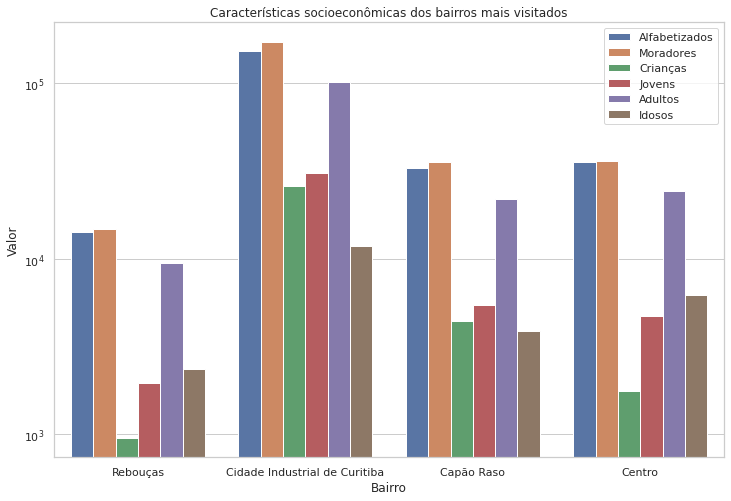

In [15]:
plt.figure(figsize=(12, 8))
sns.barplot(x='NM_BAIRRO', y='Valor', hue='Métrica', data=df_final_2[df_final_2['Métrica'] != 'Média de Rendimentos'])
plt.xlabel('Bairro')
plt.ylabel('Valor')
plt.title('Características socioeconômicas dos bairros mais visitados')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

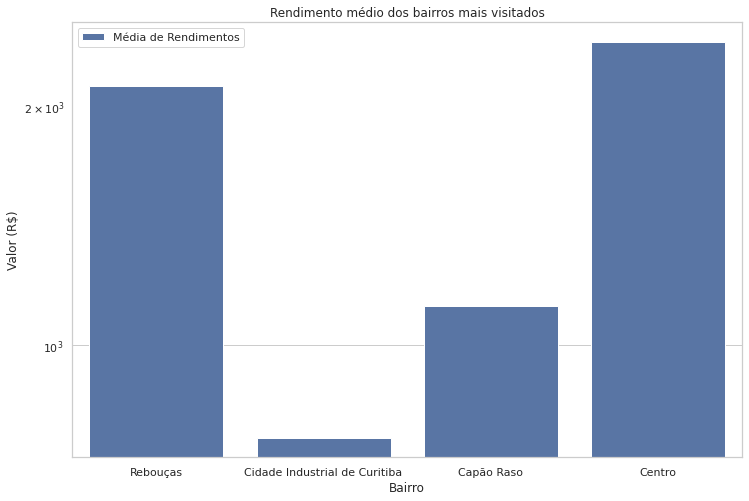

In [20]:
plt.figure(figsize=(12, 8))
sns.barplot(x='NM_BAIRRO', y='Valor', hue='Métrica', data=df_final_2[df_final_2['Métrica'] == 'Média de Rendimentos'])
plt.xlabel('Bairro')
plt.ylabel('Valor (R$)')
plt.title('Rendimento médio dos bairros mais visitados')
plt.yscale('log')
plt.legend(loc='upper left')
plt.show()

#### 2.2) Comparação com todos os setores censitários

Verificar as características gerais da cidade de Curitiba para verificar se os bairros filtrados têm mais ou menos habitantes e se são mais ricos ou mais pobres.

In [15]:
df_setor = (df_setor.groupBy('NM_BAIRRO')
            .agg(avg(df_setor.media_rendimento_medio).alias('media_dos_rendimentos_medios'),
                 sum(df_setor.n_alfabetizados).alias('n_alfabetizados'),
                 sum(df_setor.n_moradores).alias('n_moradores'),
                 sum(df_setor.n_criancas).alias('n_criancas'),
                 sum(df_setor.n_jovens).alias('n_jovens'),
                 sum(df_setor.n_adultos).alias('n_adultos'),
                 sum(df_setor.n_idosos).alias('n_idosos'))
           )
df_setor.show(5)

2022-02-20 16:10:05,238 WARN scheduler.TaskSetManager: Stage 24 contains a task of very large size (124 KB). The maximum recommended task size is 100 KB.


+--------------+----------------------------+---------------+-----------+----------+--------+---------+--------+
|     NM_BAIRRO|media_dos_rendimentos_medios|n_alfabetizados|n_moradores|n_criancas|n_jovens|n_adultos|n_idosos|
+--------------+----------------------------+---------------+-----------+----------+--------+---------+--------+
|   Guabirotuba|                 1802.540625|          10685|      11389|      1259|  1538.0|     6794|    1758|
|Alto Boqueirão|           860.1839705882352|          48399|      53563|      7771|  9012.0|    31821|    4378|
|Campo Comprido|          1568.0134999999996|          25986|      28707|      4054|  4442.0|    18073|    2015|
|       Uberaba|          1090.5977500000004|          64578|      71917|     10601| 12450.0|    41988|    5972|
|  Butiatuvinha|                 1252.391875|          11535|      12661|      1707|  2188.0|     7544|    1265|
+--------------+----------------------------+---------------+-----------+----------+--------+---

In [16]:
df_setor.drop('NM_BAIRRO').describe().toPandas().set_index('summary')

2022-02-20 16:10:11,785 WARN scheduler.TaskSetManager: Stage 30 contains a task of very large size (124 KB). The maximum recommended task size is 100 KB.


,media_dos_rendimentos_medios,n_alfabetizados,n_moradores,n_criancas,n_jovens,n_adultos,n_idosos
summary,,,,,,,
count,75,75,75,75,75,75,75
mean,1717.9193202165593,21225.18666666667,23255.053333333333,2982.6666666666665,3657.2,13983.106666666667,2429.9466666666667
stddev,921.6965511623322,25033.717032258133,27975.548057763805,4201.08933535144,4962.312824436562,16548.294997152818,2263.451537361024
min,559.10625,254,289,43,52.0,169,24
max,4257.061578947369,153513,171930,25928,30707.0,101641,11866


## 3) Área Funcional da região com maior fluxo em períodos da semana

O objetivo dessa análise é verificar o tipo de área funcional (escolar, industrial, comercial) da região com maior fluxo durante a semana e em finais de semana, no período da manhã (06h às 11h59). Além disso, é esperado que uma das duas regiões esteja presente nos resultados da primeira questão.

In [223]:
#Pegar o período do dia e filtrar por somente eventos de manhã
df = (df
      .withColumn('DAY_PERIOD', 
                     when(col('HOUR').between('06:00:00', '11:59:59'), 'morning')
                    .otherwise('other_periods'))
     )
df = df.filter(df.DAY_PERIOD == 'morning')

In [224]:
#Pegar o nome completo do dia da semana e categorizar como meio de semana ou fim de semana
df = (df
      .withColumn('WEEKDAY', date_format(col('DATE'), 'EEEE'))
      .withColumn('WEEK_PERIOD', when(col('WEEKDAY') == 'Saturday', 'WEEKEND')
                                 .when(col('WEEKDAY') == 'Sunday', 'WEEKEND')
                                 .otherwise('WORKWEEK'))
     )

In [225]:
df = df.select('WEEK_PERIOD', 'DATE', 'VEIC', 'HOUR', 'BAIRRO')

In [226]:
#Contar a ocorrência de cada ônibus em cada região em períodos da semana
df = (df
      .withColumn("ROUND_TIME", substring('HOUR', 0, 2).cast('int'))
      .select('WEEK_PERIOD', 'DATE', 'VEIC', 'BAIRRO', 'ROUND_TIME')
      .dropDuplicates()
     )
df = df.groupBy('WEEK_PERIOD', 'DATE', 'VEIC', 'BAIRRO').count()

In [227]:
#Somar a quantidade de ônibus que estavam em cada região de acordo com os períodos do dia 
df = (df
      .select('WEEK_PERIOD','BAIRRO', 'count')
      .groupBy('WEEK_PERIOD','BAIRRO')
      .agg(sum('count').alias('BUS_TOTAL'))
     )

In [229]:
w1 = Window.partitionBy(df['WEEK_PERIOD']).orderBy(df['BUS_TOTAL'].desc())
df_final_3 = (df
              .select('*', row_number().over(w1).alias('row_number')) 
              .filter(col('row_number') == 1)
              .select('WEEK_PERIOD', 'BAIRRO', 'BUS_TOTAL')
             )
df_final_3.show()

+-----------+------+---------+
|WEEK_PERIOD|BAIRRO|BUS_TOTAL|
+-----------+------+---------+
|   WORKWEEK|Centro|    27038|
|    WEEKEND|Centro|     5472|
+-----------+------+---------+



Pegar os bairros únicos resultantes para calcular a área funcional deles. Ler o arquivo com os locais presentes em cada bairro e suas respectivas funcionalidades.

In [230]:
bairros_final = df_final_3.select('BAIRRO').distinct().collect()
bairros_final = [b.BAIRRO for b in bairros_final]
bairros_final

['Centro']

In [231]:
df_roi = pd.read_csv('roi.csv')[['BAIRRO', 'FUNCIONALIDADE']]
display(df_roi.head(5))
df_roi = spark.createDataFrame(df_roi)

,BAIRRO,FUNCIONALIDADE
0,São Braz,company
1,São Braz,company
2,São Braz,company
3,São Braz,educational
4,São Braz,educational


In [232]:
df_roi = df_roi.filter(df_roi.BAIRRO.isin(bairros_final))
n_locais_centro = df_roi.count()
n_locais_centro

776

In [233]:
df_funcionalidade = df_roi.groupBy('FUNCIONALIDADE').count()
df_funcionalidade = df_funcionalidade.withColumn('percentage', round(col('count')/n_locais_centro*100, 2))

In [234]:
df_funcionalidade = df_funcionalidade.toPandas()
df_funcionalidade.FUNCIONALIDADE = df_funcionalidade.FUNCIONALIDADE.replace(['educational', 'food', 'shopping', 'sport', 'tourism', 'entertainment', 'company', 'government'],
                                                                            ['Educacional', 'Alimentação', 'Comercial', 'Esporte', 'Turismo', 'Entretenimento', 'Companhia', 'Governamental'])
df_funcionalidade

,FUNCIONALIDADE,count,percentage
0,Educacional,25,3.22
1,Alimentação,183,23.58
2,Comercial,218,28.09
3,Esporte,22,2.84
4,Turismo,110,14.18
5,Entretenimento,172,22.16
6,Companhia,24,3.09
7,Governamental,22,2.84


Plotar os resultados

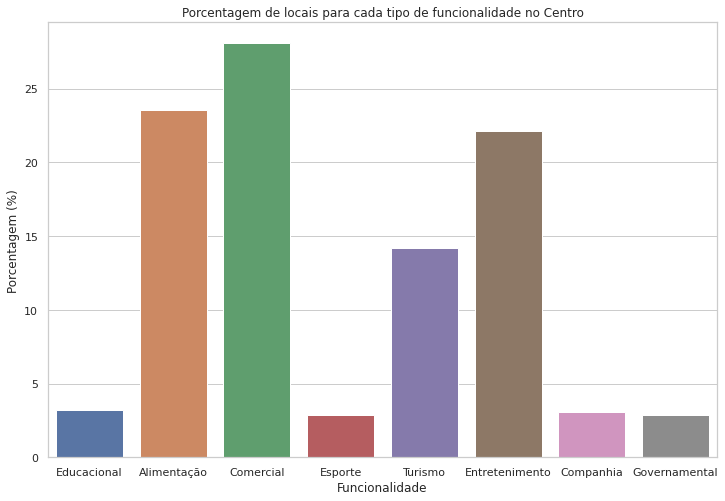

In [362]:
plt.figure(figsize=(12, 8))
sns.barplot(x='FUNCIONALIDADE', y='percentage', data=df_funcionalidade)
plt.xlabel('Funcionalidade')
plt.ylabel('Porcentagem (%)')
plt.title('Porcentagem de locais para cada tipo de funcionalidade no Centro')
plt.show()

## 4) Faixa de renda do local onde teve maior tempo de espera entre ônibus de mesma linha

In [239]:
df_cluster = (df
              .select('COD_LINHA', 'BAIRRO', 'DATE', 'LAT', 'LON', 'HOUR')
              .withColumn('HOUR_LONG', to_timestamp(col('HOUR')).cast('long'))
             )
df_cluster.show(5)

+---------+--------------------+----------+----------+----------+--------+----------+
|COD_LINHA|              BAIRRO|      DATE|       LAT|       LON|    HOUR| HOUR_LONG|
+---------+--------------------+----------+----------+----------+--------+----------+
|      658|Cidade Industrial...|2017-05-18|-25.494461|-49.327496|07:40:27|1645342827|
|      658|Cidade Industrial...|2017-05-18|-25.494476|-49.327435|07:40:25|1645342825|
|      658|Cidade Industrial...|2017-05-18|-25.494583|-49.327065|07:40:21|1645342821|
|      658|Cidade Industrial...|2017-05-18|-25.494642|-49.326843|07:40:19|1645342819|
|      658|Cidade Industrial...|2017-05-18| -25.49523|-49.324703|07:39:58|1645342798|
+---------+--------------------+----------+----------+----------+--------+----------+
only showing top 5 rows



Vamos truncar as coordenadas em 3 casas decimais para obter locais de 100m², e possibilitar agrupamento entre esses locais.

In [240]:
def truncate(coord):
    coord *= 1000
    coord = coord.astype('int')
    coord = coord.astype('float')
    coord /= 1000
    return coord

In [241]:
df_cluster = (df_cluster
              .withColumn('LAT', truncate(col('LAT')))
              .withColumn('LON', truncate(col('LON')))
             )
df_cluster.show(5)

+---------+--------------------+----------+-------+-------+--------+----------+
|COD_LINHA|              BAIRRO|      DATE|    LAT|    LON|    HOUR| HOUR_LONG|
+---------+--------------------+----------+-------+-------+--------+----------+
|      658|Cidade Industrial...|2017-05-18|-25.494|-49.327|07:40:27|1645342827|
|      658|Cidade Industrial...|2017-05-18|-25.494|-49.327|07:40:25|1645342825|
|      658|Cidade Industrial...|2017-05-18|-25.494|-49.327|07:40:21|1645342821|
|      658|Cidade Industrial...|2017-05-18|-25.494|-49.326|07:40:19|1645342819|
|      658|Cidade Industrial...|2017-05-18|-25.495|-49.324|07:39:58|1645342798|
+---------+--------------------+----------+-------+-------+--------+----------+
only showing top 5 rows



In [242]:
w1 = Window.partitionBy('COD_LINHA', 'BAIRRO', 'DATE', 'LAT', 'LON').orderBy(df_cluster['HOUR'])
df_cluster = df_cluster.withColumn('PREV_TIME', to_timestamp(lag(df_cluster['HOUR']).over(w1)).cast('long'))
df_cluster = df_cluster.withColumn('TIME_DIFF', col('HOUR_LONG')-col('PREV_TIME'))
df_cluster.show(5)

[Stage 76:>                                                         (0 + 1) / 1]

+---------+--------------+----------+-------+-------+--------+----------+----------+---------+
|COD_LINHA|        BAIRRO|      DATE|    LAT|    LON|    HOUR| HOUR_LONG| PREV_TIME|TIME_DIFF|
+---------+--------------+----------+-------+-------+--------+----------+----------+---------+
|     null|Alto da Glória|2017-05-15|-25.419|-49.264|08:16:35|1645344995|      null|     null|
|     null|Alto da Glória|2017-05-15|-25.419|-49.264|08:16:39|1645344999|1645344995|        4|
|     null|Alto da Glória|2017-05-15|-25.419|-49.264|08:25:16|1645345516|1645344999|      517|
|     null|Alto da Glória|2017-05-15|-25.419|-49.264|08:25:20|1645345520|1645345516|        4|
|     null|Alto da Glória|2017-05-15|-25.419|-49.264|08:27:11|1645345631|1645345520|      111|
+---------+--------------+----------+-------+-------+--------+----------+----------+---------+
only showing top 5 rows



In [244]:
max_diff = df_cluster.agg(max(df_cluster.TIME_DIFF)).collect()
max_diff = max_diff[0]['max(TIME_DIFF)']
print(max_diff)

[Stage 81:=====================================================>(199 + 1) / 200]

83277


In [230]:
bairro_max_diff = df_cluster.filter(df_cluster.TIME_DIFF == max_diff)
bairro_max_diff.show(5)

[Stage 501:======================================================>(74 + 1) / 75]

+---------+--------------------+----------+-------+------+--------+----------+----------+---------+
|COD_LINHA|              BAIRRO|      DATE|    LAT|   LON|    HOUR| HOUR_LONG| PREV_TIME|TIME_DIFF|
+---------+--------------------+----------+-------+------+--------+----------+----------+---------+
|      809|Cidade Industrial...|2017-05-18|-25.451|-49.36|23:56:37|1645401397|1645318120|    83277|
+---------+--------------------+----------+-------+------+--------+----------+----------+---------+



Obter a média do rendimento médio do bairro cuja diferença foi máxima, ou seja, que passou mais tempo sem um ônibus da mesma linha.

In [235]:
df_setor.filter(df_setor.NM_BAIRRO == 'Cidade Industrial de Curitiba').select('NM_BAIRRO', 'media_dos_rendimentos_medios').show()

+--------------------+----------------------------+
|           NM_BAIRRO|media_dos_rendimentos_medios|
+--------------------+----------------------------+
|Cidade Industrial...|           764.2039748953973|
+--------------------+----------------------------+



## 5) Identificador de pontos de parada

Como pontos de parada vão ter muitas localizações na região e períodos diversos do dia, não importando a ordem temporal, vamos aplicar o algoritmo DBScan para identificar esses pontos. Vale ressaltar que pontos de parada podem ser devidos à pontos de ônibus, terminais de ônibus ou semáforos.

#### 5.1)  Gerar os pontos de parada

Como o DBScan não está presente na MLLib e portanto, não está otimizado para execução Spark, vamos focar em identificar paradas somente em um bairro, no caso o Centro. Como mesmo assim seriam muitos dados, vamos usar somente a linha com mais localizações dentro do Centro

In [160]:
df_paradas = df.filter(df.BAIRRO == 'Centro')
del(df)

In [161]:
#Identificar a linha com mais localizações dentro do Centro
df_paradas.groupBy('VEIC').count().sort(desc('count')).show(5)

[Stage 5:====================================================>      (8 + 1) / 9]

+-----+-----+
| VEIC|count|
+-----+-----+
|BN997|33210|
|BN998|31250|
|BC942|30631|
|CC300|26278|
|BC926|21482|
+-----+-----+
only showing top 5 rows



In [162]:
df_paradas = df_paradas.filter(df_paradas.VEIC == 'BN997')

In [21]:
import numpy as np
import joblib

In [163]:
#Obter a matriz de coordenadas que será usada como feature. Vamos também salvar as coordenadas para que não seja necessário
#gerá-las novamente
coords = np.array(df_paradas.select('LAT', 'LON').collect())
joblib.dump(coords, 'coords_filtered.joblib')

['coords_filtered.joblib']

Gerar um Heatmap com as coordenadas que serão aplicadas ao modelo, ou seja, da rota do ônibus que está sendo avaliada.

In [22]:
import folium
from folium.plugins import HeatMap

In [26]:
mapa = folium.Map(location=[-25.4284, -49.2733],
                    zoom_start = 15)
HeatMap(coords).add_to(mapa)
mapa

In [24]:
coords = joblib.load('coords_filtered.joblib')

In [27]:
from sklearn.cluster import DBSCAN

In [165]:
#Criar e treinar o modelo usando o parâmetro de aglomeração como 50m radianos em relação à Terra.
#Vamos também assumir que para um ponto ser considerado parada, tem que ter no mínimo 30 localizações
eps = 0.001 / 6371.0088
db = DBSCAN(eps=eps, min_samples=20, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

In [166]:
import joblib
joblib.dump(db, 'dbscan_model.joblib')

['dbscan_model.joblib']

In [28]:
db = joblib.load('dbscan_model.joblib')

Obter os centróides, que serão os pontos de parada identificados.

In [9]:
import pandas as pd

In [29]:
#Computar o número de clusters/paradas identificados e pegar as localizações que estão em cada parada
n_paradas = list(set(db.labels_)-set([-1]))
paradas = pd.Series([coords[db.labels_ == prd] for prd in n_paradas])
print('Número de paradas identificadas:', len(n_paradas))

Número de paradas identificadas: 24


In [30]:
#O ponto de parada em si será computado como o centróide de todas as localizações presentes no cluster
from shapely.geometry import MultiPoint
def get_centroids(cluster):
    centroids = MultiPoint(cluster).centroid
    return [centroids.x, centroids.y]

df_centroides = pd.DataFrame(paradas.map(get_centroids).tolist() , columns=('lat', 'lon'))

In [31]:
df_coords = pd.DataFrame(coords, columns=('lat', 'lon'))

Plotar as coordenadas brutas e os pontos onde foram identificadas paradas.

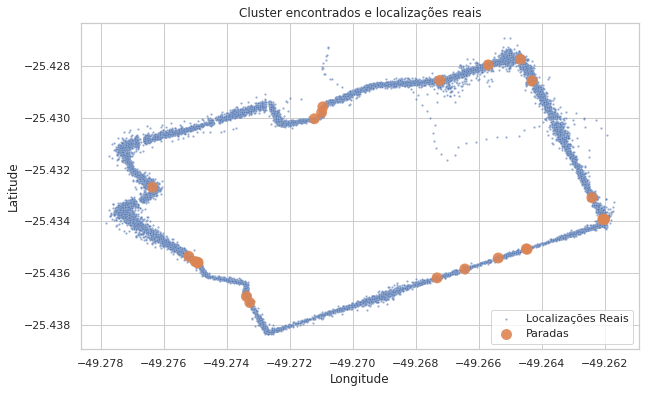

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='lon', y='lat', palette='k', alpha=0.6, s=5, label='Localizações Reais', data=df_coords)
sns.scatterplot(x='lon', y ='lat', palette='g', edgecolor='None', alpha=0.9, s=120, label='Paradas', data=df_centroides)
plt.title('Cluster encontrados e localizações reais')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='lower right')
plt.show()

In [35]:
mapa_paradas = folium.Map(location=[-25.4284, -49.2733],
                    zoom_start = 15)

df_coords['labels'] = db.labels_
df_coords = np.array(df_coords[(df_coords.labels != -1)][['lat', 'lon']].values.tolist())
HeatMap(df_coords).add_to(mapa_paradas)

point_paradas = np.array(df_centroides.values.tolist())
for p in point_paradas:
    folium.Marker([p[0], p[1]], popup='Parada').add_to(mapa_paradas)
mapa_paradas

#### 5.2) Importar os pontos de parada do OSM para comparar com as paradas encontradas

Iremos testar pontos de parada com buffers de 10 e 20 metros.

In [36]:
from shapely import wkt, geometry

In [37]:
stops = pd.read_csv('stops.csv', index_col=0)
stops['geometry'] = stops['geometry'].apply(wkt.loads)
stops['buffer10m'] = stops['buffer10m'].apply(wkt.loads)
stops['buffer20m'] = stops['buffer20m'].apply(wkt.loads)
stops['buffer30m'] = stops['buffer30m'].apply(wkt.loads)
stops['buffer50m'] = stops['buffer50m'].apply(wkt.loads)
stops.head(2)

,name,geometry,key,value,function,buffer10m,buffer20m,buffer50m,buffer30m
335,NaN,POINT (-49.2644985 -25.4282276),highway,bus_stop,bus_stop,"POLYGON ((-49.2643985 -25.4281276, -49.2643985...","POLYGON ((-49.2642985 -25.4280276, -49.2642985...","POLYGON ((-49.2641985 -25.4279276, -49.2641985...","POLYGON ((-49.2641985 -25.4279276, -49.2641985..."
1402,NaN,POINT (-49.2618004 -25.4281438),highway,traffic_signals,traffic_signals,"POLYGON ((-49.2617004 -25.4280438, -49.2617004...","POLYGON ((-49.2616004 -25.4279438, -49.2616004...","POLYGON ((-49.2615004 -25.4278438, -49.2615004...","POLYGON ((-49.2615004 -25.4278438, -49.2615004..."


In [38]:
stops['value'].value_counts()

traffic_signals    211
bus_stop            91
bus_station         18
Name: value, dtype: int64

In [39]:
def is_stop (lat, lon, column):
    intersection = stops.apply(lambda stp: stp['value'] if stp[column].contains(geometry.Point(lon, lat)) else None, axis=1).dropna()
    if len(intersection) == 0:
        return None
    return intersection.values[0]

In [40]:
def print_precision(buffer):
    intersections = df_centroides.apply(lambda row: is_stop(row.lat, row.lon, buffer), axis=1)
    stops_identified = intersections.dropna()
    
    #Calcular as paradas identificadas e quantas foram preditas
    total_identified = len(stops_identified)
    total_predicted = len(intersections)
    tam_buffer = buffer[-3:]
    precision = (total_identified/total_predicted)*100
    
    print('-----> Precisão com buffer de ', tam_buffer, ': ', precision, '%', sep='')
    print(total_identified, 'paradas identificadas de um total de', total_predicted)
    print()
    
    stops_identified = stops_identified.value_counts()
    return [tam_buffer, precision, total_identified, stops_identified]

In [41]:
#Gerar precisão para os diferentes tamanhos de buffer
precisions = []
for buff in ['buffer10m', 'buffer20m', 'buffer30m', 'buffer50m']:
    precisions.append(print_precision(buff))

-----> Precisão com buffer de 10m: 20.833333333333336%
5 paradas identificadas de um total de 24

-----> Precisão com buffer de 20m: 66.66666666666666%
16 paradas identificadas de um total de 24

-----> Precisão com buffer de 30m: 83.33333333333334%
20 paradas identificadas de um total de 24

-----> Precisão com buffer de 50m: 83.33333333333334%
20 paradas identificadas de um total de 24



Gerar os dataframes para plotar os resultados.

In [42]:
precisions = pd.DataFrame(precisions, columns=('tam_buffer', 'precision', 'total_identified', 'stops_identified'))
precisions['stops_type'] = precisions.stops_identified.apply(lambda v: v.index.values)
precisions['stops_type_count'] = precisions.stops_identified.apply(lambda v: v.values)
precisions = precisions.drop('stops_identified', axis=1)
precisions

,tam_buffer,precision,total_identified,stops_type,stops_type_count
0,10m,20.833333,5,[traffic_signals],[5]
1,20m,66.666667,16,"[traffic_signals, bus_station]","[15, 1]"
2,30m,83.333333,20,"[traffic_signals, bus_station, bus_stop]","[16, 3, 1]"
3,50m,83.333333,20,"[traffic_signals, bus_station, bus_stop]","[16, 3, 1]"


In [43]:
precision_summary = precisions[['tam_buffer', 'precision', 'total_identified']]
precision_summary = pd.melt(precision_summary, id_vars=['tam_buffer'], value_vars=['precision', 'total_identified'],var_name='Métrica', value_name='Valor')
precision_summary['Métrica'] = precision_summary['Métrica'].replace(['precision', 'total_identified'], ['Precisão (%)', 'Identificadas'])

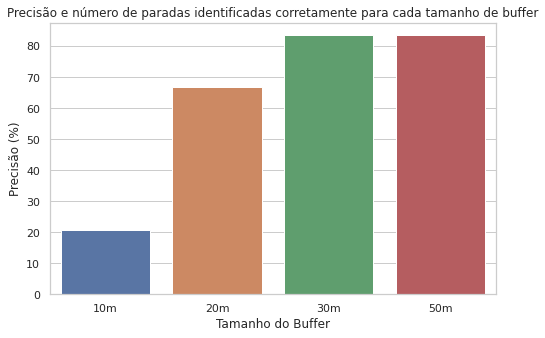

In [45]:
plt.figure(figsize=(8, 5))
sns.barplot(x='tam_buffer', y='Valor', data=precision_summary[precision_summary['Métrica'] == 'Precisão (%)'].sort_values(by='tam_buffer'))
plt.xlabel('Tamanho do Buffer')
plt.ylabel('Precisão (%)')
plt.title('Precisão e número de paradas identificadas corretamente para cada tamanho de buffer')
plt.show()

In [379]:
precision_details = precisions[['tam_buffer', 'stops_type', 'stops_type_count']]
precision_details = precision_details.explode(['stops_type', 'stops_type_count'])

In [381]:
precision_details.stops_type = precision_details.stops_type.replace(['traffic_signals', 'bus_station', 'bus_stop'], ['Semáforo', 'Estação de Ônibus', 'Ponto de Ônibus'])

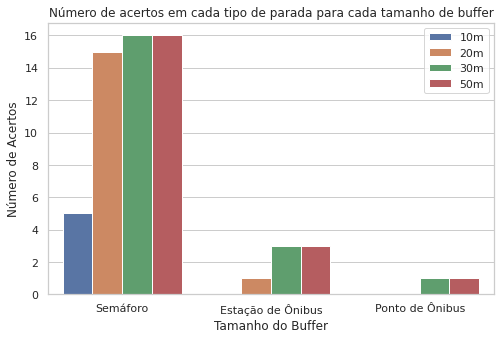

In [384]:
plt.figure(figsize=(8, 5))
sns.barplot(x='stops_type', y='stops_type_count', hue='tam_buffer', data=precision_details.sort_values(by='tam_buffer'))
plt.xlabel('Tamanho do Buffer')
plt.ylabel('Número de Acertos')
plt.title('Número de acertos em cada tipo de parada para cada tamanho de buffer')
plt.legend(loc='upper right')
plt.show()

Plotar os pontos de parada que foram gerados e os pontos de parada reais com buffer de 30m.

In [28]:
buffer = stops['buffer30m'].reset_index(drop=True)

In [36]:
mapa_paradas = folium.Map(location=[-25.4284, -49.2733],
                    zoom_start = 14)
for buff in buffer:
    folium.GeoJson(buff).add_to(mapa_paradas)

point_paradas = np.array(df_centroides.values.tolist())
for p in point_paradas:
    folium.Marker([p[0], p[1]], popup='Parada').add_to(mapa_paradas)
mapa_paradas